# Part 3. Benchmarking Model

## Importing libraries and setting global variables

In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling library
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

## Importing datasets

In [2]:
def read_train_test(status='train'):
    # Function to select dataset to read
    if status == 'train':
        df = pd.read_csv('../datasets/train_cleaned.csv')
    elif status == 'test':
        df = pd.read_csv('../datasets/test_cleaned.csv')
    else:
        print(f"Select the correct dataset")
    return df

In [3]:
# Select 'train' to read train.csv
# Select 'test' to read test.csv
df = read_train_test('train')

In [4]:
df.shape

(2092, 60)

In [5]:
# View head
df.head(5)

,ms_zoning,lot_frontage,street,lot_shape,lot_contour,utilities,lot_config,lot_slope,neighborhood,condition_1,...,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck,log_sale_price,log_lot_area
0,Res,80.0,1,1,1,AllPub,Corner,1,SawyerW,N,...,159000,0,2436.0,1,1.5,1,0,0,11.976659,9.170039
1,Res,90.0,1,0,1,AllPub,CulDSac,1,SawyerW,N,...,271900,0,4354.0,1,2.0,1,1,1,12.513190,9.594514
2,Res,60.0,1,0,1,NoSeWa,CulDSac,1,Timber,N,...,137500,0,2163.0,1,1.5,1,1,0,11.831379,9.573246
3,Res,48.0,1,1,1,AllPub,Inside,1,NridgHt,N,...,248500,0,2907.0,1,2.0,1,1,1,12.423198,8.775240
4,Res,61.0,1,0,1,AllPub,Inside,1,Gilbert,R,...,167000,1,1758.0,1,2.5,0,0,0,12.025749,9.183380


# Benchmarking model

#### Create function to run linear regression

In [6]:
def linreg_bench(X,y,t_s=0.2):
    # function to create benchmarking model
    
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=t_s,random_state=42)
    
    # instantiate and fit the model
    lr = LinearRegression() 
    lr.fit(X_train,y_train)
    
    # create predictions
    y_train_preds = lr.predict(X_train)
    y_test_preds = lr.predict(X_test)

    # train/test R^2 score
    train_r2 = lr.score(X_train,y_train)
    test_r2 = lr.score(X_test,y_test)

    # cross validation score
    mean_cross_val = cross_val_score(lr, X_train, y_train)

    # RMSE calculation
    rmse_train = round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)
    rmse_test = round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)
    
    # print results
    print()
    print(" Linear Model ".center(30, "="))
    print()
    print(f"train r2: {train_r2.round(4)}")
    print(f"test_r2: {test_r2.round(4)}")
    print(f"mean cross val: {mean_cross_val.round(4)}")
    print(f"train rmse: {rmse_train}")
    print(f"test rmse: {rmse_test}")
    
    # generate plot
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    # calculate correlation
    cor = np.corrcoef(y_test,y_test_preds)
    
    # plot 1 (left) - scatter plot of y_test vs y_test_preds
    # plots
    plot1 = sns.scatterplot(ax=axes[0],x=y_test,y=y_test_preds)
    sns.lineplot(ax=axes[0],x=y_test,y=y_test)
    # style
    plot1.set_xlabel('y_test')
    plot1.set_ylabel('y_test_preds')
    plot1.set_title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})")
    
    # plot 2 (right) - histogram y_test vs y_test_preds
    # plots
    plot2 = sns.histplot(ax=axes[1],x=y_test,color='grey',alpha=0.5)
    plot2 = sns.histplot(ax=axes[1],x=y_test_preds)
    # style
    plot2.set_xlabel('sale_price')
    plot2.set_title(f"y_test vs y_test_preds - Histogram");
    
    return y_test,y_test_preds

Selecting Columns (Benchmarking will use the top 5 corelated features after cleaning)

In [7]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)[:7]

In [8]:
# Training
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


======== Linear Model ========

train r2: 0.8324
test_r2: 0.8313
mean cross val: [0.836  0.8153 0.8336 0.824  0.8261]
train rmse: 31982.68
test rmse: 31419.8


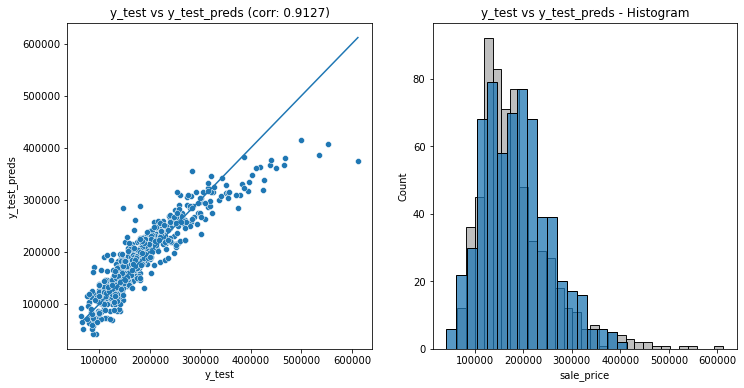

In [9]:
# Running the model
y_test,y_test_preds = linreg_bench(X,y,0.3)

__Interpretation:__
- The features that we've cleaned up has performed well without overfitting
- THe R2 scores of training and testing datasets were very similar (only 0.01 off)
- However, we are not predicting very well around the high prices
- Moving forward, RMSE for benchmarking will be 30,429

----